# 📊 Visual Analysis of Customer Retention

**Author:** Viktoria Kazniienko  
**Date:** 2025-12-29  
**Data Source:** Online Retail Dataset (Cleaned)

## 🎯 Objectives
The goal of this notebook is to visualize customer behavior and retention patterns to answer the following business questions:
1.  **Retention Health:** How well do we keep customers after their first purchase?
2.  **Cohort Comparison:** Are newer customers behaving differently than older ones?
3.  **Loyalty:** What is the ratio of one-time buyers vs. repeat customers?
4.  **Timing:** When is the best time to re-engage a customer?

---

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

In [3]:
os.makedirs('../outputs/figures', exist_ok=True)

In [4]:
df = pd.read_csv('../data/processed/online_retail_db.csv', 
                 dtype={'invoice_no': str}, 
                 low_memory=False)

In [5]:
df['invoice_date'] = pd.to_datetime(df['invoice_date'])
df['order_month'] = pd.to_datetime(df['order_month'])
df['cohort_month'] = pd.to_datetime(df['cohort_month'])

## Cohort Retention Heatmap

**Goal:** Visualize the specific percentage of active customers for each cohort over time. 
This is the most critical view for understanding the "lifecycle" of a user base.

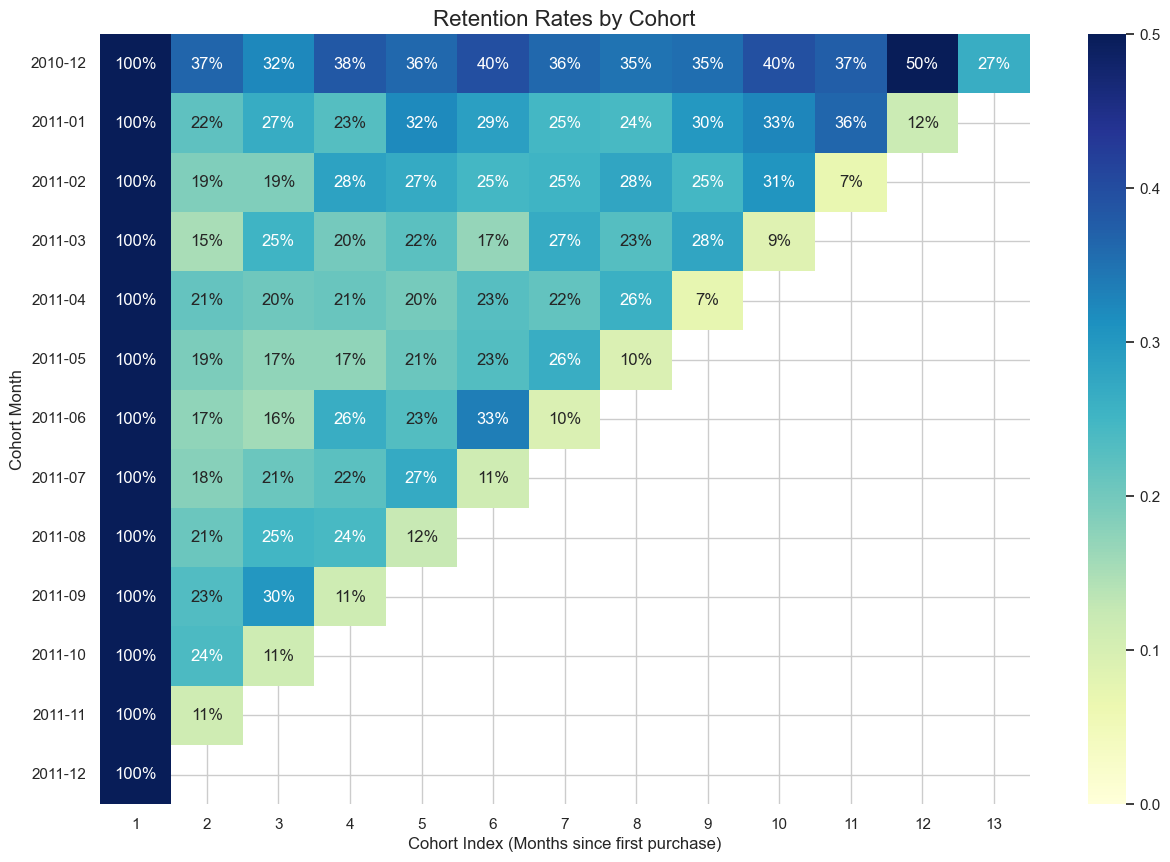

In [6]:
# 1. Готуємо матрицю (Pivot Table)
cohort_data = df.groupby(['cohort_month', 'cohort_index'])['customer_id'].nunique().reset_index()
cohort_counts = cohort_data.pivot(index='cohort_month', columns='cohort_index', values='customer_id')

# 2. Розрахунок Retention (ділимо все на перший місяць)
cohort_sizes = cohort_counts.iloc[:, 0]
retention = cohort_counts.divide(cohort_sizes, axis=0)

# 3. Будуємо Heatmap
plt.figure(figsize=(15, 10))
plt.title('Retention Rates by Cohort', fontsize=16)

# Перетворимо індекс у гарний формат дати для підписів (YYYY-MM)
retention.index = retention.index.strftime('%Y-%m')

sns.heatmap(data=retention, 
            annot=True, 
            fmt='.0%', 
            vmin=0.0, 
            vmax=0.5,
            cmap='YlGnBu')

plt.ylabel('Cohort Month')
plt.xlabel('Cohort Index (Months since first purchase)')
plt.yticks(rotation=0)

# 7️⃣ Збереження
plt.savefig('../outputs/figures/retention_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

### 💡 Key Insights:

1.  **Sharp Drop-off (The "Cliff"):**
    * We see a significant drop in retention immediately after the first month. across all cohorts. 
    * On average, retention drops from **100% to ~20-37%** in the second month. This indicates that the majority of customers are "one-time buyers".

2.  **Strong Seasonality (December Effect):**
    * The **2010-12 Cohort** is the strongest. Interestingly, in their 12th month (Index 12), retention jumps back up to **50%**.
    * Since Index 12 for the "2010-12" cohort corresponds to **December 2011**, this confirms high seasonal demand. Customers acquired during the holidays tend to return for the next holiday season.

3.  **Cohort Degradation:**
    * Newer cohorts (e.g., `2011-04`, `2011-05`) show slightly lower initial retention (dropping to ~19-21% in month 2) compared to the first cohort (37%). This might indicate that the quality of acquired traffic is slightly decreasing or competition is increasing.

## Retention Curves (Line Chart)

**Goal:** Compare the performance of different cohorts directly. 
While the heatmap shows values, the line chart makes it easier to spot trends, outliers, and the rate of decline.

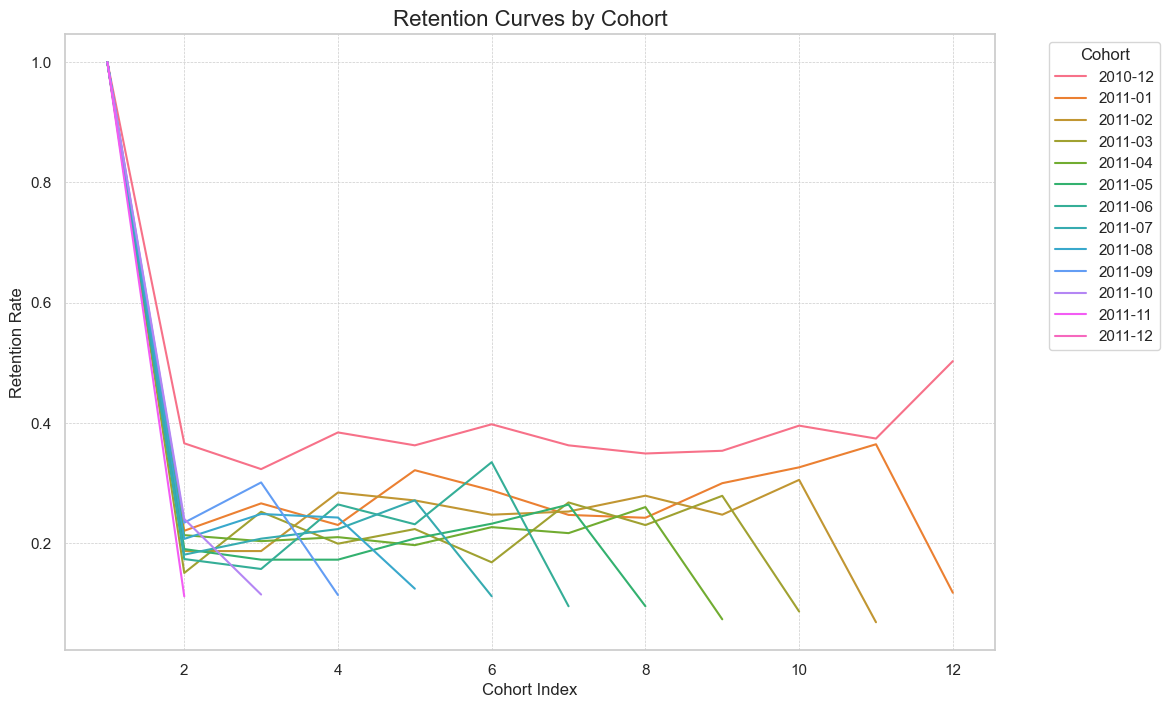

In [7]:
plt.figure(figsize=(12, 8))
plt.title('Retention Curves by Cohort', fontsize=16)

# Малюємо лінії (транспонуємо матрицю, щоб індекси були по осі X)
# Беремо тільки перші 12 місяців для чистоти
sns.lineplot(data=retention.T.iloc[:12, :], dashes=False)

plt.xlabel('Cohort Index')
plt.ylabel('Retention Rate')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Cohort')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# 7️⃣ Збереження
plt.savefig('../outputs/figures/retention_curves.png', dpi=300, bbox_inches='tight')
plt.show()

### 💡 Key Insights:

1.  **The "Golden" Cohort (2010-12):**
    * The **red line (2010-12)** is consistently higher than all others. 
    * While other cohorts drop to ~20% retention in Month 2, this cohort stays above **35%**. This suggests that customers acquired during the Christmas season are significantly more valuable and loyal.

2.  **Cohort Bunching:**
    * Most of the 2011 cohorts (green/blue lines) are clustered together at the bottom (15-25% retention). This indicates a stable, albeit lower, baseline performance for "regular" months.

3.  **Stabilization:**
    * After the initial drop in Month 2 (Index 2), the curves flatten out. This is a positive sign: if we can convince a customer to make a *second* purchase, they are highly likely to stick around for the long term.

## 3. Repeat Purchase Distribution

**Goal:** Understand customer loyalty distribution.

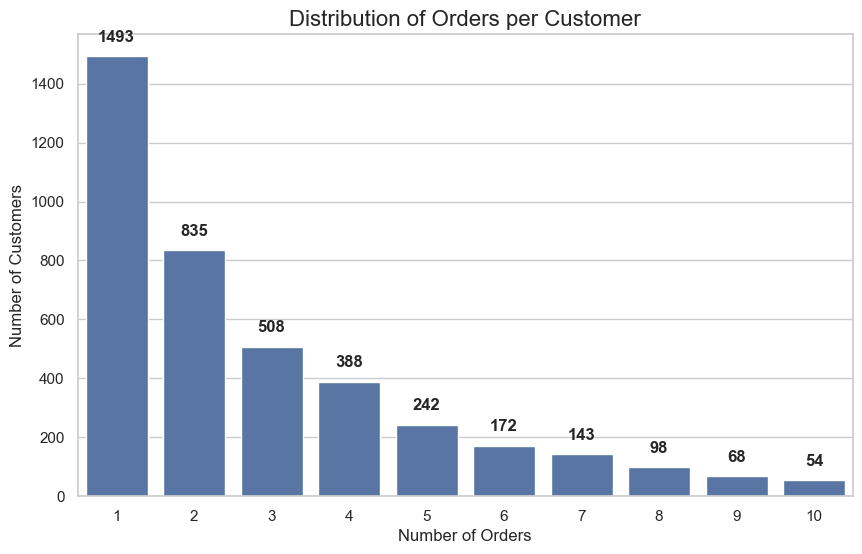

In [8]:
# Рахуємо кількість замовлень на кожного клієнта
customer_orders = df.groupby('customer_id')['invoice_no'].nunique()

# Рахуємо розподіл (скільки людей купили 1 раз, 2 рази і т.д.)
# Обрізаємо "хвіст" до 10 покупок для краси графіка
plot_data = customer_orders.value_counts().sort_index().head(10)

plt.figure(figsize=(10, 6))
barplot = sns.barplot(x=plot_data.index, y=plot_data.values, color='#4c72b0')

plt.title('Distribution of Orders per Customer', fontsize=16)
plt.xlabel('Number of Orders')
plt.ylabel('Number of Customers')

# Додаємо підписи значень над стовпчиками (Visualization Hygiene)
for i, v in enumerate(plot_data.values):
    plt.text(i, v + 50, str(v), ha='center', fontweight='bold')

# 7️⃣ Збереження
plt.savefig('../outputs/figures/repeat_purchase_dist.png', dpi=300, bbox_inches='tight')
plt.show()

### 💡 Key Insights:

1.  **The Drop-off:**
    * The largest group is **One-time buyers (1493 customers)**. This is typical for retail.
    * However, the drop-off to **2 orders (835 customers)** is not catastrophic. A significant portion of users (~35% of this top sample) move to the second purchase.

2.  **The Loyal Tail:**
    * We see a healthy "tail" of users making 5+ purchases (242 customers made exactly 5 orders). These are likely the "Whales" driving a large portion of revenue.

## 4. Time to Second Purchase

**Goal:** Determine the optimal window for re-engagement.
For those customers who *did* return, how long did it take?
* **Peak:** The most common number of days between orders.
* **Median:** The "middle" value, which is robust against outliers.

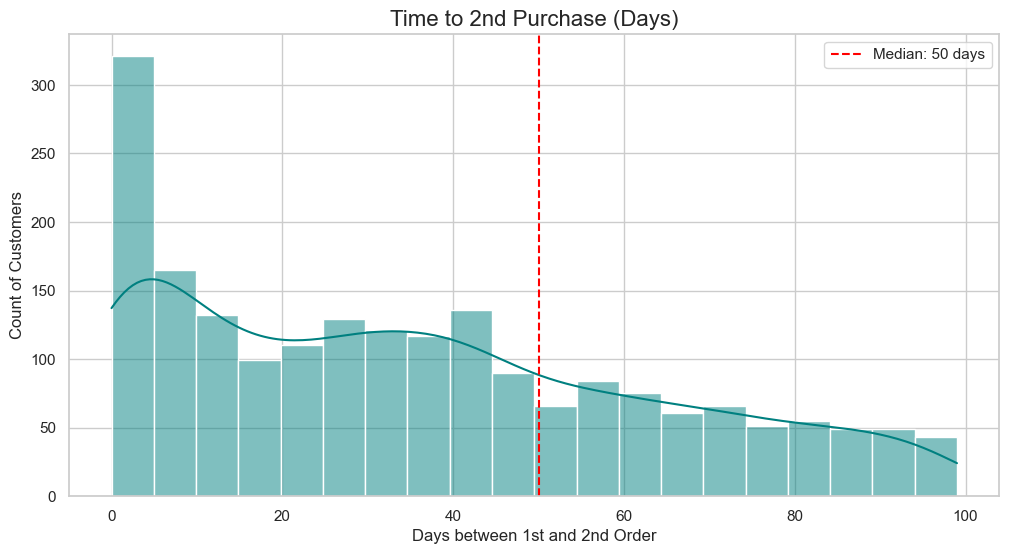

In [9]:
# 1. Відбираємо клієнтів з >= 2 покупками
multiple_orders = df.groupby('customer_id').filter(lambda x: x['invoice_no'].nunique() >= 2)

# 2. Сортуємо і беремо 1-шу та 2-гу покупку
multiple_orders = multiple_orders.drop_duplicates(subset=['customer_id', 'invoice_no'])
multiple_orders = multiple_orders.sort_values(['customer_id', 'invoice_date'])

# Групуємо і рахуємо різницю днів
# shift(-1) зсуває дату на рядок вгору
time_diff = multiple_orders.groupby('customer_id')['invoice_date'].apply(
    lambda x: (x.iloc[1] - x.iloc[0]).days if len(x) > 1 else None
).dropna()

plt.figure(figsize=(12, 6))
sns.histplot(time_diff[time_diff < 100], bins=20, kde=True, color='teal')

plt.title('Time to 2nd Purchase (Days)', fontsize=16)
plt.xlabel('Days between 1st and 2nd Order')
plt.ylabel('Count of Customers')
plt.axvline(time_diff.median(), color='red', linestyle='--', label=f'Median: {int(time_diff.median())} days')
plt.legend()

plt.savefig('../outputs/figures/time_to_2nd_purchase.png', dpi=300, bbox_inches='tight')
plt.show()

### 💡 Key Insights:

1.  **The 50-Day Benchmark:**
    * The median time to the second purchase is **50 days** (red dotted line).
    * This means 50% of returning customers come back within less than 2 months.

2.  **Immediate Repeats:**
    * The highest bar is in the **0-10 days** range. This suggests a specific behavior: customers buying, liking the product, and immediately ordering more (or forgetting something in the first order).

3.  **Actionable Strategy:**
    * **Day 7-14:** Send a "Thank you / Review request" (captures the immediate repeats).
    * **Day 45-50:** **CRITICAL WINDOW.** Send a "Restock" or "New Arrival" email just before the median time. This is the moment most users are naturally ready to buy again.

# 🎯 Final Conclusion & Business Recommendations

Based on the visualized data, we can draw the following strategic conclusions:

1.  **Retention Focus:** Retention rates flatten out after Month 2. The primary goal of the marketing team should be **Activation** — getting the customer to make that *second* purchase. Once they do, they are much more likely to stay.
2.  **Seasonal Opportunity:** The December cohort is our best performer. We should analyze the marketing campaigns from Dec 2010 to replicate that success in future holiday seasons.
3.  **Marketing Timing:** Automated email flows should be set up with a **45-50 day trigger**. Waiting longer than 3 months (90 days) significantly reduces the chance of reactivation, as shown by the long tail in the "Time to Purchase" graph.